In [205]:
from convolution import SeConvolve
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import math
import matplotlib.image as mpimg
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [233]:
class HOGDescriptor:
    def __init__(self):
        
        # Gradient x and y operations Prewitt's Operators
        self._convolution_matrix_gx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
        self._convolution_matrix_gy = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
        
        self.output_class = dict()
        self.output_dist = dict()
        
        #### Train ####
        self.training_discript = dict()
        self.train_images = list()
        self.number_of_train_positive = 0
        self.image_names_train = list()
        self.gray_train_images = list()

        # Output of step 2
        self._gradient_x_train = list()
        self._gradient_y_train = list()
        self._gradient_x_norm_train = list()
        self._gradient_y_norm_train = list()
        # Output of step 3
        self._magnitude_train = list()
        self._magnitude_norm_train = list()
        # Angle Output
        self._angle_train = list()
        self._edge_angle_train = list()
        
        #### Test ####
        self.test_discript = dict()
        self.test_images = list()
        self.number_of_test_positive = 0
        self.image_names_test = list()
        self.gray_test_images = list() 
        # Output of step 2
        self._gradient_x_test = list()
        self._gradient_y_test = list()
        self._gradient_x_norm_test = list()
        self._gradient_y_norm_test = list()
        # Output of step 3
        self._magnitude_test = list()
        self._magnitude_norm_test = list()
        # Angle Output
        self._angle_test = list()
        self._edge_angle_test = list()

    def fit(self):
        my_list = os.listdir('train/positive')
        self.image_names_train.extend(my_list)

        for current in my_list:
            image = mpimg.imread("train/positive/" + current)
            pixels = np.array(image)
            self.train_images.append(pixels)
        
        self.number_of_train_positive = len(self.train_images)

        my_list = os.listdir('train/negative')
        self.image_names_train.extend(my_list)

        for current in my_list:
            image = mpimg.imread("train/negative/" + current)
            pixels = np.array(image)
            self.train_images.append(pixels)
        
        self.train_images = np.array(self.train_images)
        
#         self.to_grayscale(self.train_images, train=True)

#         self.gradient_operation(self, self.gray_train_images)

#         self.hog_feature(self._magnitude_train, self._angle_train, train=True)

    
    def test(self):
        my_list = os.listdir('test/positive')
        self.image_names_test.extend(my_list)

        for current in my_list:
            image = mpimg.imread("test/positive/" + current)
            pixels = np.array(image)
            self.test_images.append(pixels)
        
        self.number_of_test_positive = len(self.test_images)

        my_list = os.listdir('test/negative')
        self.image_names_test.extend(my_list)

        for current in my_list:
            image = mpimg.imread("test/negative/" + current)
            pixels = np.array(image)
            self.test_images.append(pixels)
        
        self.test_images = np.array(self.test_images)
        
#         self.to_grayscale(self.test_images, train=False)

#         self.gradient_operation(self, self.gray_test_images)

#         self.hog_feature(self._magnitude_test, self._angle_test, train=False)

    def evaluate(self):
        
        for classes, disc in self.test_discript.items():
            
            distance = np.empty(0)
            class_distance = np.empty(0)
            
#             file_name = classes.split('-')[0]
#             class_name = classes.split('-')[-1]
            disc = np.array(disc)
            
            for classes_tr, disc_tr in self.training_discript.items():
            
#                 file_name_tr = classes_tr.split('-')[0]
#                 class_name_tr = classes_tr.split('-')[-1]
                disc_tr = np.array(disc_tr)
                
                denominator = np.sum(disc_tr)
                numerator = np.minimum(disc_tr,disc)
                numerator = np.sum(numerator)
                
                distance = np.append(distance, numerator/denominator)
                class_distance = np.append(class_distance, classes_tr)
            
            c = {A: B for A, B in zip(class_distance, distance)}
            c = dict(sorted(c.items(), key=lambda item: item[1], reverse=True))
            
            i = 0
            temp1 = list()
            temp2 = list()
            while i < 3:
                
                cl = list(c.keys())[i]
                cl = cl.split('-')[-1]
                temp1.append(cl)
                
                di = list(c.values())[i]
                temp2.append(di)
                
                i += 1
            
            self.output_class[classes] = temp1
            self.output_dist[classes] = temp2
    
    def hog_feature(self, magn, angle, train=True):

        for index, image in enumerate(magn):
            row = 0
            
            image_discriptor = np.empty(0)
            
            while row <= 160:
                row_start = row
                row_end = row + 16

                if not row_end <= 160:
                    break
                    
                col = 0
                while col <= 96:
                    count_col = 0
                    column_start = col
                    column_end = col + 16
                    
                    if column_end <= 96:
                        current_block_magnitude = magn[index][row_start:row_end, column_start:column_end]
                        current_block_angle = angle[index][row_start:row_end, column_start:column_end]
                        
                        hist = self.HOG_cell(current_block_magnitude, current_block_angle)
                        
                        image_discriptor = np.concatenate((image_discriptor, hist), axis=0)
                    else:
                        break
                    
                    col += 8
                
                row += 8
            
            if train:
                if index < self.number_of_train_positive:
                    self.training_discript[self.image_names_train[index] + '-positive'] = image_discriptor
                else:
                    self.training_discript[self.image_names_train[index] + '-negative'] = image_discriptor
            else:
                if index < self.number_of_test_positive:
                    self.test_discript[self.image_names_test[index] + '-positive'] = image_discriptor
                else:
                    self.test_discript[self.image_names_test[index] + '-negative'] = image_discriptor
    
    def HOG_cell(self, current_block_magnitude, current_block_angle):
        
        hist1 = self.HOG_cell_histogram(current_block_magnitude[0:8, 0:8], current_block_angle[0:8, 0:8])
        
        hist2 = self.HOG_cell_histogram(current_block_magnitude[0:8, 8:16], current_block_angle[0:8, 8:16])
        
        hist3 = self.HOG_cell_histogram(current_block_magnitude[8:16, 0:8], current_block_angle[8:16, 0:8])
        
        hist4 = self.HOG_cell_histogram(current_block_magnitude[8:16, 8:16], current_block_angle[8:16, 8:16])
        
        hist = np.concatenate((hist1, hist2, hist3, hist4), axis=0)
        
        norm = np.linalg.norm(hist)
        
        if norm > 0:
            hist = hist / norm
        
        return hist
        
    
    def HOG_cell_histogram(self, current_block_magnitude, current_block_angle):
        
        bins = [0] * 9
        
        i = 0
        
        while i <= current_block_magnitude.shape[0] - 1:
            
            j = 0
            
            while j <= current_block_magnitude.shape[1] - 1:
                
                angle = current_block_angle[i, j]
                
                if angle >= 180:
                    angle = angle - 180
                
                if angle < 0:
                    angle = angle + 180
                    
                if 0 <= angle < 20:
                    bins[0] += current_block_magnitude[i, j]
                elif 20 <= angle < 40:
                    bins[1] += current_block_magnitude[i, j]
                elif 40 <= angle < 60:
                    bins[2] += current_block_magnitude[i, j]
                elif 60 <= angle < 80:
                    bins[3] += current_block_magnitude[i, j]
                elif 80 <= angle < 100:
                    bins[4] += current_block_magnitude[i, j]
                elif 100 <= angle < 120:
                    bins[5] += current_block_magnitude[i, j]
                elif 120 <= angle < 140:
                    bins[6] += current_block_magnitude[i, j]
                elif 140 <= angle < 160:
                    bins[7] += current_block_magnitude[i, j]
                elif 160 <= angle < 180:
                    bins[8] += current_block_magnitude[i, j]
                else:
                    print('some error')
                
                j += 1
            
            i += 1
        
        return np.array(bins)
    
    def to_grayscale(self, images, train=True):
        
        if train:
            for image in images:
                new_image = np.round(np.dot(image[...,:3], [0.299, 0.587, 0.114]))
                self.gray_train_images.append(new_image)
            
            self.gray_train_images = np.array(self.gray_train_images)
        else:
            for image in images:
                new_image = np.round(np.dot(image[...,:3], [0.299, 0.587, 0.114]))
                self.gray_test_images.append(new_image)
            
            self.gray_test_images = np.array(self.gray_test_images)

    def gradient_operation(self, images, train=True):

        if train:
            for image in images:
                
                # Convolution done on the image_matrix w.r.t gradient x
                gradient_x = SeConvolve(image, self._convolution_matrix_gx, mode='gradient')
                gradient_x_train, gradient_x_norm_x_train = gradient_x.convolution()
                
                self._gradient_x_train.append(gradient_x_train)
                self._gradient_x_norm_train.append(gradient_x_norm_x_train)
                
                # Convolution done on the image_matrix w.r.t gradient y
                gradient_y = SeConvolve(image, self._convolution_matrix_gy, mode='gradient')
                gradient_y_train, gradient_y_norm_train = gradient_y.convolution()
                
                self._gradient_y_train.append(gradient_y_train)
                self._gradient_y_norm_train.append(gradient_y_norm_train)
                
                # We compute gradient magnitude, gradient angle and edge angle
                magnitude_x_train, magnitude_norm_x_train = self.calcuate_magnitude(gradient_x_train, gradient_y_train)
                angle_x_train, edge_angle_x_train = self.calculate_angle(gradient_x_train, gradient_y_train)
                
                self._magnitude_train.append(magnitude_x_train)
                self._magnitude_norm_train.append(magnitude_norm_x_train)
                
                self._angle_train.append(angle_x_train)
                self._edge_angle_train.append(edge_angle_x_train)
            
            self._gradient_x_train = np.array(self._gradient_x_train)
            self._gradient_x_norm_train = np.array(self._gradient_x_norm_train)
            self._gradient_y_train = np.array(self._gradient_y_train)
            self._gradient_y_norm_train = np.array(self._gradient_y_norm_train)
            self._magnitude_train = np.array(self._magnitude_train)
            self._magnitude_norm_train = np.array(self._magnitude_norm_train)
            self._angle_train = np.array(self._angle_train)
            self._edge_angle_train = np.array(self._edge_angle_train)
        else:
            for image in images:
                
                # Convolution done on the image_matrix w.r.t gradient x
                gradient_x = SeConvolve(image, self._convolution_matrix_gx, mode='gradient')
                gradient_x_train, gradient_x_norm_x_train = gradient_x.convolution()
                
                self._gradient_x_test.append(gradient_x_train)
                self._gradient_x_norm_test.append(gradient_x_norm_x_train)
                
                # Convolution done on the image_matrix w.r.t gradient y
                gradient_y = SeConvolve(image, self._convolution_matrix_gy, mode='gradient')
                gradient_y_train, gradient_y_norm_train = gradient_y.convolution()
                
                self._gradient_y_test.append(gradient_y_train)
                self._gradient_y_norm_test.append(gradient_y_norm_train)
                
                # We compute gradient magnitude, gradient angle and edge angle
                magnitude_x_train, magnitude_norm_x_train = self.calcuate_magnitude(gradient_x_train, gradient_y_train)
                angle_x_train, edge_angle_x_train = self.calculate_angle(gradient_x_train, gradient_y_train)
                
                self._magnitude_test.append(magnitude_x_train)
                self._magnitude_norm_test.append(magnitude_norm_x_train)
                
                self._angle_test.append(angle_x_train)
                self._edge_angle_test.append(edge_angle_x_train)
            
            self._gradient_x_test = np.array(self._gradient_x_test)
            self._gradient_x_norm_test = np.array(self._gradient_x_norm_test)
            self._gradient_y_test = np.array(self._gradient_y_test)
            self._gradient_y_norm_test = np.array(self._gradient_y_norm_test)
            self._magnitude_test = np.array(self._magnitude_test)
            self._magnitude_norm_test = np.array(self._magnitude_norm_test)
            self._angle_test = np.array(self._angle_test)
            self._edge_angle_test = np.array(self._edge_angle_test)
            
            
    
    def calcuate_magnitude(self, gradient_x, gradient_y):
        height, width = gradient_x.shape

        # After gaussing smoothing and gradient computation we have lost a total of 8 rows and 8 columns
        magnitude = np.zeros((height - 2, width - 2))

        # looping over the desired matrix
        for i in range(1,height - 1):
            for j in range(1,width - 1):
                # gradient calculated using root(gx**2 + gy**2)
                temp = (gradient_x[i, j] ** 2) + (gradient_y[i, j] ** 2)
                
                magnitude[i - 1, j - 1] = math.sqrt(temp)

        # Nomralization of Magnitude
        magnitude_norm = magnitude / 360.624
        # same size as original image
        magnitude = np.pad(magnitude, 1, mode='constant')
        magnitude_norm = np.pad(magnitude_norm, 1, mode='constant')

        return magnitude, magnitude_norm
    
    def calculate_angle(self, gradient_x, gradient_y):
        
        height, width = gradient_x.shape
        
        # After gaussing smoothing and gradient computation we have lost a total of 8 rows and 8 columns
        angle = np.zeros((height - 2, width - 2))
        edge_angle = np.zeros((height - 2, width - 2))
        
        # looping over the desired matrix
        for i in range(1,height - 1):
            for j in range(1,width - 1):
                if gradient_x[i, j]  != 0:
                    # gradient angle computed using tan-1(gy/gx)
                    angle[i - 1, j - 1] = math.degrees(math.atan((gradient_y[i, j] / gradient_x[i, j])))
                    edge_angle[i - 1, j - 1] = angle[i - 1, j - 1] + 90
        
        # same size as original image
        angle = np.pad(angle, 1, mode='constant')
        edge_angle = np.pad(angle, 1, mode='constant')

        return angle, edge_angle

In [234]:
hg = HOGDescriptor()

In [235]:
hg.fit()

In [236]:
hg.train_images.shape

(20, 160, 96, 3)

In [237]:
hg.to_grayscale(hg.train_images)

In [238]:
hg.gray_train_images[0].shape

(160, 96)

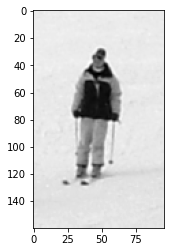

In [239]:
plt.imshow(hg.gray_train_images[0], cmap='gray')

In [240]:
hg.gradient_operation(hg.gray_train_images)

In [241]:
magn = hg._magnitude_train

In [242]:
angle = hg._angle_train

In [243]:
magn.shape

(20, 160, 96)

In [244]:
magn[0]

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.

In [245]:
hg.hog_feature(magn, angle)

In [246]:
len(hg.training_discript)

20

In [247]:
hg.training_discript.keys()

dict_keys(['crop001008b.bmp-positive', 'crop001028a.bmp-positive', 'crop001030c.bmp-positive', 'crop001045b.bmp-positive', 'crop001047b.bmp-positive', 'crop001063b.bmp-positive', 'crop001275b.bmp-positive', 'crop001672b.bmp-positive', 'crop_000010b.bmp-positive', 'person_and_bike_026a.bmp-positive', '00000053a_cut.bmp-negative', '00000057a_cut.bmp-negative', '00000062a_cut.bmp-negative', '00000091a_cut.bmp-negative', '00000093a_cut.bmp-negative', '01-03e_cut.bmp-negative', 'no_person__no_bike_213_cut.bmp-negative', 'no_person__no_bike_219_cut.bmp-negative', 'no_person__no_bike_247_cut.bmp-negative', 'no_person__no_bike_259_cut.bmp-negative'])

In [248]:
hg.training_discript['crop001008b.bmp-positive'].shape

(7524,)

# Test

In [249]:
hg.test()

In [250]:
hg.test_images.shape

(10, 160, 96, 3)

In [251]:
hg.to_grayscale(hg.test_images, False)

In [252]:
hg.gray_test_images.shape

(10, 160, 96)

In [253]:
hg.gradient_operation(hg.gray_test_images, False)

In [254]:
magn = hg._magnitude_test
angle = hg._angle_test

In [255]:
hg.hog_feature(magn, angle, False)

In [256]:
len(hg.test_discript)

10

In [257]:
hg.test_discript.keys()

dict_keys(['crop001034b.bmp-positive', 'crop001070a.bmp-positive', 'crop001278a.bmp-positive', 'crop001500b.bmp-positive', 'person_and_bike_151a.bmp-positive', '00000003a_cut.bmp-negative', '00000090a_cut.bmp-negative', '00000118a_cut.bmp-negative', 'no_person__no_bike_258_Cut.bmp-negative', 'no_person__no_bike_264_cut.bmp-negative'])

In [258]:
hg.test_discript['crop001034b.bmp-positive'].shape

(7524,)

In [259]:
hg.evaluate()

In [260]:
hg.output_class

{'crop001034b.bmp-positive': ['positive', 'positive', 'negative'],
 'crop001070a.bmp-positive': ['positive', 'positive', 'positive'],
 'crop001278a.bmp-positive': ['positive', 'positive', 'positive'],
 'crop001500b.bmp-positive': ['positive', 'negative', 'positive'],
 'person_and_bike_151a.bmp-positive': ['positive', 'positive', 'positive'],
 '00000003a_cut.bmp-negative': ['negative', 'positive', 'negative'],
 '00000090a_cut.bmp-negative': ['negative', 'negative', 'positive'],
 '00000118a_cut.bmp-negative': ['negative', 'negative', 'negative'],
 'no_person__no_bike_258_Cut.bmp-negative': ['negative',
  'positive',
  'positive'],
 'no_person__no_bike_264_cut.bmp-negative': ['negative',
  'positive',
  'negative']}

In [261]:
hg.output_dist

{'crop001034b.bmp-positive': [0.6344744736533708,
  0.6171574124296783,
  0.6171472264915788],
 'crop001070a.bmp-positive': [0.4696845699534709,
  0.46916485332874763,
  0.46916213564693],
 'crop001278a.bmp-positive': [0.5639640515903805,
  0.5577732603207997,
  0.5544930851477459],
 'crop001500b.bmp-positive': [0.525025757126381,
  0.5194298377304222,
  0.5073124935799236],
 'person_and_bike_151a.bmp-positive': [0.4804707522319749,
  0.47969800260107676,
  0.46866727319381885],
 '00000003a_cut.bmp-negative': [0.5492738048020572,
  0.5450832536030286,
  0.5184120883616412],
 '00000090a_cut.bmp-negative': [0.4569912666267593,
  0.4423499148685365,
  0.41471956062948795],
 '00000118a_cut.bmp-negative': [0.5272319806770444,
  0.5165865076415262,
  0.5116533838295101],
 'no_person__no_bike_258_Cut.bmp-negative': [0.4619899843197705,
  0.46169673599674754,
  0.4593726127808326],
 'no_person__no_bike_264_cut.bmp-negative': [0.40940314362823826,
  0.40347137005019923,
  0.39820722187798524]}